#Importing neccessary libraries including Pytorch

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [4]:
data = pd.read_csv('amazon-stocks.csv')

In [5]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6516 entries, 0 to 6515
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6516 non-null   object 
 1   Open       6516 non-null   float64
 2   High       6516 non-null   float64
 3   Low        6516 non-null   float64
 4   Close      6516 non-null   float64
 5   Adj Close  6516 non-null   float64
 6   Volume     6516 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 356.5+ KB


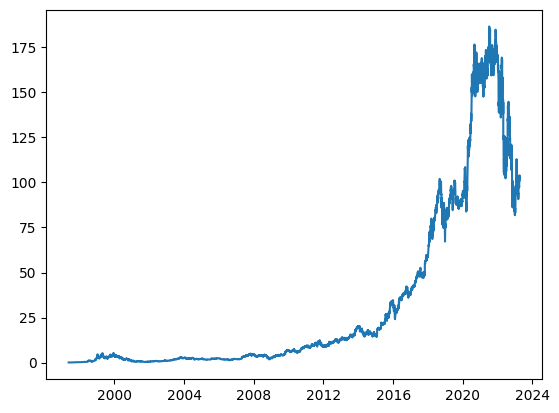

In [7]:
data['Date'] = pd.to_datetime(data['Date'])
plt.plot(data['Date'], data['Close'])

In [8]:
data = data[['Date', 'Close']]
data

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417
3,1997-05-20,0.081771
4,1997-05-21,0.071354
...,...,...
6511,2023-03-30,102.000000
6512,2023-03-31,103.290001
6513,2023-04-03,102.410004
6514,2023-04-04,103.949997


Creating new Dataframe for LSTM because LSTM requires current date's closing value, a day before that, and a day before and so on.

In [9]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    
    df.set_index('Date', inplace=True)
    
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

lookback = 7 #no. of days to lookback
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354
...,...,...,...,...,...,...,...,...
2023-03-30,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997,100.610001
2023-03-31,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997
2023-04-03,102.410004,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999


so basically what we trying to do is to let LSTM take the current date's close value and all the way to t-7 as X and next date's Close value as Y. just like classification, this way model should predict the next date's closing vlaue

In [10]:
#converting dataframe to numpy
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[7.91670000e-02, 7.50000000e-02, 6.97920000e-02, ...,
        8.54170000e-02, 8.64580000e-02, 9.79170000e-02],
       [7.65630000e-02, 7.91670000e-02, 7.50000000e-02, ...,
        8.17710000e-02, 8.54170000e-02, 8.64580000e-02],
       [7.52600000e-02, 7.65630000e-02, 7.91670000e-02, ...,
        7.13540000e-02, 8.17710000e-02, 8.54170000e-02],
       ...,
       [1.02410004e+02, 1.03290001e+02, 1.02000000e+02, ...,
        9.80400010e+01, 9.81299970e+01, 9.87099990e+01],
       [1.03949997e+02, 1.02410004e+02, 1.03290001e+02, ...,
        9.72399980e+01, 9.80400010e+01, 9.81299970e+01],
       [1.01099998e+02, 1.03949997e+02, 1.02410004e+02, ...,
        1.00250000e+02, 9.72399980e+01, 9.80400010e+01]])

Preprocessing

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)
shifted_df_as_np

array([[-0.99991063, -0.99995531, -1.        , ..., -0.99983244,
        -0.99982128, -0.99969839],
       [-0.99993855, -0.99991063, -0.99994415, ..., -0.99987154,
        -0.99983244, -0.99982128],
       [-0.99995253, -0.99993855, -0.99989946, ..., -0.99998325,
        -0.99987154, -0.99983244],
       ...,
       [ 0.09747299,  0.10690997,  0.09308121, ...,  0.0506149 ,
         0.05158   ,  0.05779984],
       [ 0.11398769,  0.09747299,  0.10691495, ...,  0.04203581,
         0.0506149 ,  0.05158   ],
       [ 0.08342464,  0.11398769,  0.09747802, ...,  0.07431453,
         0.04203581,  0.0506149 ]])

In [12]:
x = shifted_df_as_np[:, 1:] 
#picks whole 1st row means horizontal X axis on above data table acts as our data

y = shifted_df_as_np[:, 0] 
#picks 1st column and its all rows means vertical Y axis on above table acts as our predictor

x.shape, y.shape

((6509, 7), (6509,))

In next step we will Flip the arrangements of t-1 to t-7 in a descending order because the way LSTM works is that it takes older values first and then converges towards recent or updated values. In the table, t-7 means it is a seven days old value whereas t-1 means this price is just 1 day old.
Therefore we want to fit t-7 first then t-6, t-5, t-4, t-3, t-2, and then t-1 in the model.

In [13]:
x = dc(np.flip(x, axis=1))
x

array([[-0.99969839, -0.99982128, -0.99983244, ..., -0.99998325,
        -1.        , -0.99995531],
       [-0.99982128, -0.99983244, -0.99987154, ..., -1.        ,
        -0.99994415, -0.99991063],
       [-0.99983244, -0.99987154, -0.99998325, ..., -0.99994415,
        -0.99989946, -0.99993855],
       ...,
       [ 0.05779984,  0.05158   ,  0.0506149 , ...,  0.07431453,
         0.09308121,  0.10690997],
       [ 0.05158   ,  0.0506149 ,  0.04203581, ...,  0.09308121,
         0.10691495,  0.09747299],
       [ 0.0506149 ,  0.04203581,  0.07431453, ...,  0.10691495,
         0.09747802,  0.11398769]])

manually preparing split index to split data in train and test

In [14]:
split_index = int(len(x) * 0.95) #basically this means first 95% of the values will go in to training
split_index

6183

So now splitting X and Y in to X_train, Y_train and X_test, Y_test

In [15]:
X_train = x[:split_index] #X_train will be X up until split index
X_test = x[split_index:] #X_test will be from X split index onwards

Y_train = y[:split_index] #Y_train will be Y up until split index
Y_test = y[split_index:] #Y_test will be from Y split index onwards

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((6183, 7), (326, 7), (6183,), (326,))

In [16]:
#reshaping in to 3d numpy array
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

Y_train = Y_train.reshape((-1, 1))
Y_test = Y_test.reshape((-1, 1))

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((6183, 7, 1), (326, 7, 1), (6183, 1), (326, 1))

Since we are going to use Pytorch, so now we will convert these numpy arrays in to pytorch tensors

In [17]:
X_train = torch.tensor(X_train).float()
Y_train = torch.tensor(Y_train).float()
X_test = torch.tensor(X_test).float()
Y_test = torch.tensor(Y_test).float()

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

(torch.Size([6183, 7, 1]),
 torch.Size([326, 7, 1]),
 torch.Size([6183, 1]),
 torch.Size([326, 1]))

When training models in Pytorch, we need Datasets rather than raw tensors

In [18]:
#converting tensors in to datasets
from torch.utils.data import Dataset

class Time_Series_Dataset(Dataset):
    def __init__(self, x,y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x) #here x means both x and y
    
    def __getitem__(self, n):
        return self.x[n], self.y[n]
    
train_dataset = Time_Series_Dataset(X_train, Y_train)
test_dataset = Time_Series_Dataset(X_test, Y_test)

In [19]:
train_dataset, test_dataset

(<__main__.Time_Series_Dataset at 0x1fe4e010c90>,
 <__main__.Time_Series_Dataset at 0x1fe4e433bd0>)

Wrapping those raw tensors in to Dataloaders as well

In [20]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [21]:
#creating batches from dataloader
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0], batch[1] #to device function removed
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


Creating an LSTM model

In [22]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size) #to(device removed)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size) #to(device removed)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model #to(device) removed

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [23]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0], batch[1] #to(device) removed
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print average of every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [25]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0], batch[1] #to(device) removed
        
        with torch.no_grad(): #we don't need gradient here because we are not updating anything
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [26]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.088
Batch 200, Loss: 0.050
Batch 300, Loss: 0.039

Val Loss: 0.064
***************************************************

Epoch: 2
Batch 100, Loss: 0.015
Batch 200, Loss: 0.009
Batch 300, Loss: 0.005

Val Loss: 0.013
***************************************************

Epoch: 3
Batch 100, Loss: 0.002
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.007
***************************************************

Epoch: 4
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.005
***************************************************

Epoch: 5
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.004
***************************************************

Epoch: 6
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.004
***************************************************

Epoch: 7
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.005
*****************

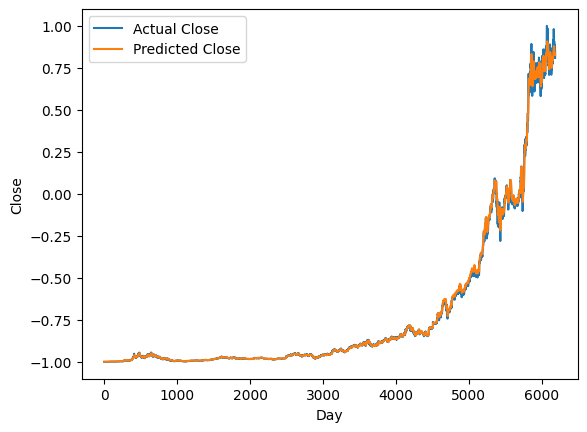

In [27]:
with torch.no_grad():
    predicted = model(X_train).numpy() #to(device) removed

plt.plot(Y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [28]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([  0.19511263,   0.19434561,   0.19358971, ..., 170.8224769 ,
       170.37219667, 170.49604833])

In [30]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = Y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([7.91646265e-02, 7.65634249e-02, 7.52572660e-02, ...,
       1.69091505e+02, 1.73315001e+02, 1.68871003e+02])

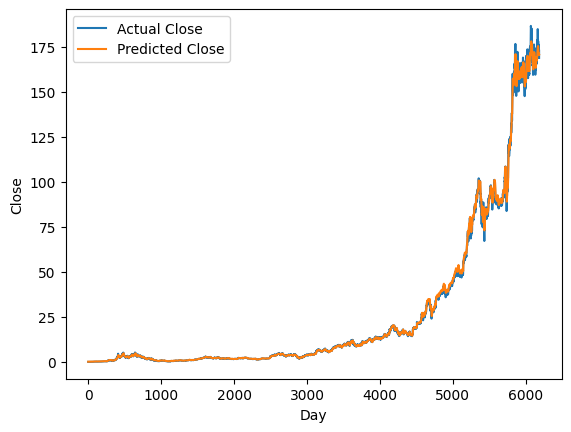

In [31]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [33]:
test_predictions = model(X_test).detach().numpy().flatten() #to(device) removed

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([169.82691701, 169.38993737, 168.70288666, 168.68124333,
       168.90201198, 169.09432303, 168.91737463, 169.07565886,
       168.96664183, 168.85305603, 168.31737524, 168.38468967,
       168.05722173, 167.28754396, 166.38847309, 165.5578505 ,
       164.68007836, 164.63218401, 164.51419062, 163.8941264 ,
       163.62355697, 162.91019967, 161.79935319, 159.97193125,
       156.3912772 , 153.48911434, 150.27902592, 147.17868263,
       144.93768631, 144.29742944, 145.45551996, 147.35872135,
       148.80681807, 147.70654314, 150.57396216, 153.17923787,
       155.72664795, 157.57426811, 158.6500206 , 158.47841911,
       158.98808788, 158.72776763, 158.77679027, 158.05605734,
       157.05843538, 155.85937593, 153.96814674, 153.44179249,
       153.55278264, 153.62797849, 153.43576748, 153.57102996,
       152.99038952, 152.15090172, 149.28924647, 146.21786657,
       144.31904498, 144.62013406, 144.78925663, 144.42553306,
       145.50493724, 148.12057328, 151.22609674, 154.41

In [35]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = Y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([170.01749949, 167.07899763, 170.41700626, 171.03700377,
       171.0684961 , 169.66949429, 170.66099675, 169.20100565,
       168.64449858, 166.71699707, 170.40449492, 167.52200227,
       164.35699578, 163.25399737, 162.55400179, 161.48599177,
       165.36199892, 165.20699954, 161.21400501, 162.13799851,
       158.91749416, 156.29899568, 151.66749509, 142.64300408,
       144.54400445, 139.98599336, 138.87249844, 139.63749627,
       143.97799855, 149.57350001, 151.19349835, 150.61250219,
       138.84550541, 157.63949825, 157.93550165, 161.41349717,
       161.18949925, 159.003495  , 153.29350176, 155.1670061 ,
       156.51049894, 158.10049453, 154.6524962 , 152.60149876,
       150.19749381, 144.82699629, 151.35800212, 153.78849709,
       153.56300403, 151.14199678, 152.05250627, 147.89849848,
       145.64100565, 137.45300383, 136.01449488, 139.27900567,
       146.81750468, 145.52450739, 141.8529947 , 147.36650272,
       153.10400311, 157.23899657, 161.25050521, 161.49

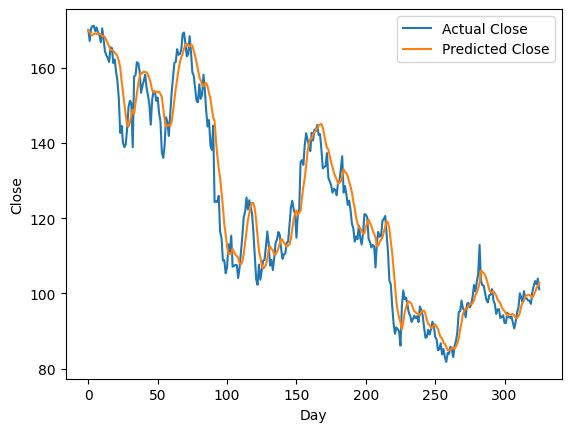

In [36]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()